In [1]:
import re
import ast
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

In [4]:
out_df = pd.read_json(f"../data/annotated/mfc_annotated_Mistral.json", lines=True)
len(out_df)
frame_map = json.load(open("../data/raw/mfc_v4.0/codes.json",'r'))

In [5]:
multiple_labels_df = pd.read_csv("../data/processed/mfc_multi_label.csv")
multiple_labels_df = multiple_labels_df.dropna()

In [6]:
clean_preds = []
for ind, pred in enumerate(out_df['predictions']):
    pred = pred.replace("\n","")
    reasoning_begins = [m.start()-1 for m in re.finditer('"reasoning"', pred)]
    reasoning_ends = [pred[loc:].find("}") for loc in reasoning_begins]
    frame_annos = []
    prev = 0
    try:
        for i, (b,e) in enumerate(zip(reasoning_begins, reasoning_ends)):
            if i == 0:
                try:
                    frame_json = json.loads(pred[1:b-1]+"}")
                    frame_json['reasoning'] = pred[b+15:b+e-1]
                    frame_annos.append(frame_json)
                except:
                    continue
            else:
                try:
                    frame_json = json.loads("{" + pred[prev+1:b-1] + "}")
                    frame_json['reasoning'] = pred[b+15:b+e-1]
                    frame_annos.append(frame_json)
                except:
                    continue
            if i < len(reasoning_begins)-1:
                gap = pred[b+e:].index("{")
                prev = b+e+gap
    except:
        pass
    clean_preds.append(frame_annos)

In [7]:
out_df['clean_preds'] = clean_preds
out_df['pred_frames'] = out_df['clean_preds'].apply(lambda x: [frame_map[str(frame_json['frame_id'])+'.0'] if str(frame_json['frame_id'])+'.0' in frame_map.keys() else None for frame_json in x ])

In [8]:
print(len(multiple_labels_df.dropna()), len(out_df))

31210 31210


In [9]:
out_df['multiple_labels'] = [ast.literal_eval(x) for x in multiple_labels_df['multiple_labels_names'].values]

In [10]:
correct = []
for ind, row in out_df[['pred_frames','multiple_labels']].iterrows():
    flag = 0
    for label in row['pred_frames']:
        if label in row['multiple_labels']:
            flag = 1
    if flag:
        correct.append(True)
    else:
        correct.append(False)

In [11]:
correct = np.array(correct)
np.unique(correct, return_counts=True)

(array([False,  True]), array([ 7045, 24165]))

In [12]:
# Multiple prediction, multi-label accuracy
sum(correct == True)/len(out_df)

0.7742710669657161

In [13]:
out_df['correct'] = correct

In [30]:
from pdb import set_trace

In [93]:
frame_pred_list = []
total_preds = 0
missing_count = 0
for i in out_df['clean_preds']:
    for j in i:
        total_preds += 1
        try:
            frame_pred_list.append((j['frame_id'],j['frame_name']))
        except:
            missing_count += 1
            print(j)

{'frame_id': 'Other', 'confidence': 20, 'reasoning': 'The article does not fit neatly into any of the other frames as it primarily discusses economic and policy aspects of climate change.'}
{'frame_id': 'Cultural identity', 'confidence': 70, 'reasoning': "The article mentions the defendant's targeting of Jewish facilities and his self-identification as a white supremacist, which can be framed as cultural identity issues."}
{'frame_id': 'Legality, constitutionality and jurisprudence', 'confidence': 70, 'reasoning': 'The article mentions the right to keep and bear arms, which is a constitutional right in the United States.'}
{'frame_id': 'Cultural identity', 'confidence': 70, 'reasoning': 'The article mentions the political affiliations of those surveyed, indicating a cultural identity frame.'}
{'frame_id': 15, 'other': 'Other, Legal - constitutionality and jurisprudence', 'confidence': 60, 'reasoning': 'The article mentions the failed Senate vote on the gun restriction measure and the c

In [94]:
bad_name_count = 0
predicted_ids = []
predicted_names = []
for id, name in frame_pred_list:
    if name not in frame_map.values():
        bad_name_count += 1
    else:
        predicted_ids.append(id)
        predicted_names.append(name)


In [95]:
print(f"Total predictions: {total_preds},\nMissing id or name in json: {missing_count}")
print(f"Frame name not from list: {bad_name_count}")

Total predictions: 93852,
Missing id or name in json: 22
Frame name not from list: 51604


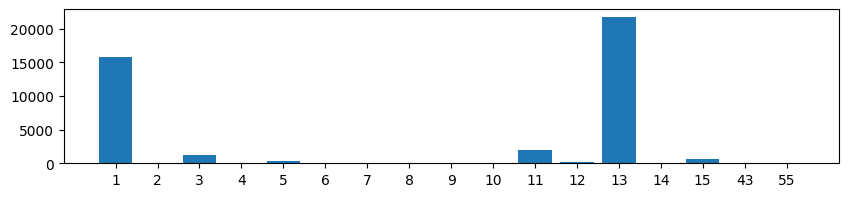

In [ ]:
labels, counts = np.unique(predicted_ids, return_counts=True)
labels = [str(l) for l in labels]
plt.figure(figsize=(10,2))
plt.bar(labels, counts)
plt.show()

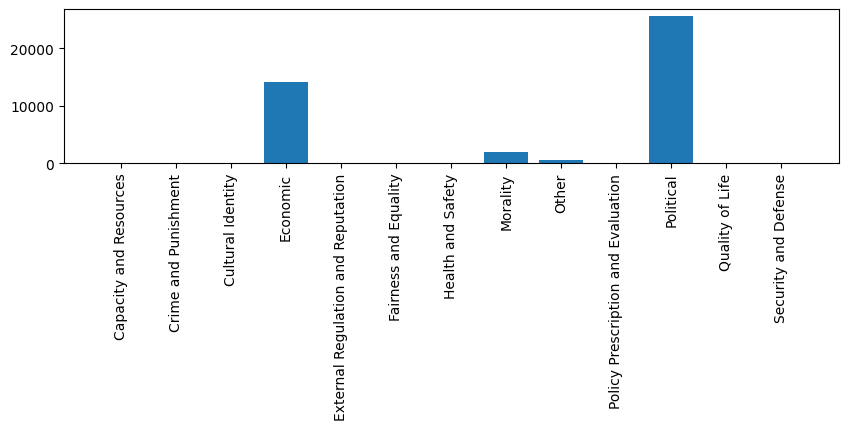

In [ ]:
labels, counts = np.unique(predicted_names, return_counts=True)
# labels = [str(l) for l in labels]
plt.figure(figsize=(10,2))
plt.bar(labels, counts)
plt.xticks(rotation=90)
plt.show()

In [47]:
frame_map_inv = {i:k for k,i in frame_map.items()}
predicted_name_mapped = [int(frame_map_inv[i][:-2]) for i in predicted_names]

In [55]:
accuracy_score(predicted_name_mapped, predicted_ids)

0.893170084781888

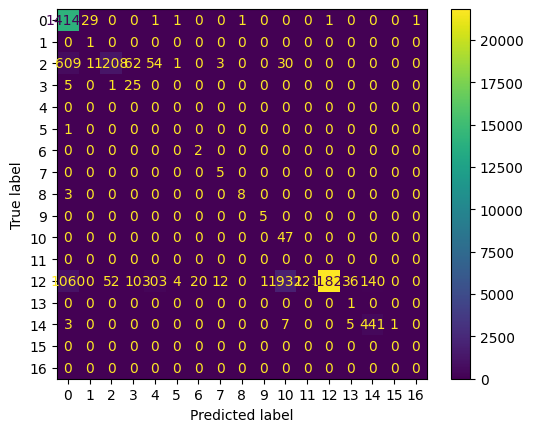

In [69]:
cfm = confusion_matrix(predicted_name_mapped, predicted_ids)
disp = ConfusionMatrixDisplay(confusion_matrix=cfm)
disp.plot()